# CS 1656 – Introduction to Data Science (Fall 2020) 

## Instructor: Alexandros Labrinidis /Teaching Assistant: Evangelos Karageorgos

## Term Project 

**Released: October 21, 2020**

**Due: December 2, 2020**

### Goal
The goal of this project is to expose you with a real data science problem, looking at the end-to-end pipeline. 

### What to do 
You are asked to write a Python Jupyter notebook, called `pgh_bike.ipynb` that will:
* [Task 1] access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data  
* [Task 2] create graphs to show the popularity of the different rental stations, given filter conditions  
* [Task 3] create graphs to show the rebalancing issue  
* [Task 4] cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.  

**Your program should not take more than 15 minutes to run**

### Jupyter Notebook Rules
This skeleton is provided for you to complete the project. Please add your code in the code cells below each Task. Feel free to add cells as needed. Do not remove existing cells.

In [131]:
import matplotlib.pyplot as plt
import pandas as pd

# Feel free to add here any other libraries as specified in the project description

For the sake of interactive display in Jupyter, we will enable matplotlib inline.

In [132]:
%matplotlib inline

### [Task 0] Warming Up
Task 0 is for testing. It is used to ensure that this Jupyter Notebook skeleton works on both your machines and our machine. Please run the following code to see if you can see a line plot. The line plot is the basic plot that we have seen in Recitation2. 

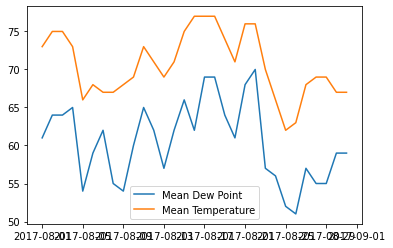

In [133]:
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df = pd.read_csv('KPIT_Aug17.csv', sep=',', engine='python', parse_dates=['EST'])
p1 = plt.plot(df['EST'],df['MeanDew PointF'])
p2 = plt.plot(df['EST'],df['Mean TemperatureF'])
plt.legend([p1[0],p2[0]], ['Mean Dew Point', 'Mean Temperature'])

plt.show()

--- 
Add your code below this line

---
### Task 1

In this task you will need to access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data.

### Task 1.1

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from _datetime import datetime
from pandas.plotting import register_matplotlib_converters
from sortedcontainers import SortedDict, SortedSet, SortedList
import math
import calendar
from sklearn import cluster
from collections import Counter
from dateutil import parser

pd.set_option('display.max_columns', None)
dfQ1 = pd.read_csv("HealthyRideRentals2019-Q1.csv")
dfQ2 = pd.read_csv("HealthyRideRentals2019-Q2.csv")
dfQ3 = pd.read_csv("HealthyRideRentals2019-Q3.csv")
# {StationId :{day:[from,to,balancing]} }
station_records = dict(dict(dict()))
station_ids = []
# keeps the time info to calculate rebalancing
# {bikeID:{date_time:[from,to]} }
dates_time = dict(SortedDict([]))
# use a sorted date list to use as column names later
date_as_column = SortedList()
#print(dfQ2)

quaters = [dfQ1,dfQ2,dfQ3]
for df in quaters:
    for index, row in df.iterrows():
        from_sta_id = row['From station id']
        to_sta_id = row['To station id']
        bike_id = row['Bikeid'] 
        #print(row['Starttime'])
        #start_date = datetime.strptime(,'%m/%d/%y %H:%M')
        start_date = parser.parse(row['Starttime'])
        stop_date = parser.parse(row['Stoptime'])
        #stop_date = datetime.strptime(row['Stoptime'],'%m/%d/%y %H:%M')
        start_day = start_date.date()
        stop_day = stop_date.date()
        # store the start time of each bike in sorted order
        if bike_id in dates_time:
            new_list = [from_sta_id, to_sta_id,start_day]
            dates_time[bike_id].update({stop_date:new_list})
        else:
            dates_time[bike_id] = {stop_date: [from_sta_id, to_sta_id,start_day]}
        if start_day not in date_as_column:
            date_as_column.add(start_day)
        if stop_day not in date_as_column:
            date_as_column.add(stop_day)
        #print(day,date)
        # check if the from station_id is valid
        #print(type(from_sta_id),from_sta_id)
        if not math.isnan(from_sta_id):
            if from_sta_id in station_records:
                if start_day in station_records[from_sta_id]:
                    station_records[from_sta_id][start_day]['fromCNT'] += 1
                else:
                    new_day = {'fromCNT': 1,'toCNT': 0,'rebalCNT': 0}
                    station_records[from_sta_id][start_day] = new_day
            else:
                station_records[from_sta_id] = {start_day: {'fromCNT': 1,'toCNT': 0,'rebalCNT': 0}}
        # check if the to station_id is valid

        if not math.isnan(to_sta_id):
            if to_sta_id in station_records:
                if stop_day in station_records[to_sta_id]:
                    station_records[to_sta_id][stop_day]['toCNT'] += 1
                else:
                    new_day = {'fromCNT': 0,'toCNT': 1,'rebalCNT': 0}
                    station_records[to_sta_id][stop_day] = new_day
            else:
                station_records[to_sta_id] = {stop_day: {'fromCNT': 0,'toCNT': 1,'rebalCNT': 0}}
#sort the dictionary
sorted_dates_time = dict(dict([]))
for id,times in dates_time.items():
    sorted_dates_time[id] = {}
    sorted_times = sorted(times.keys())
    new_dict = dict()
    for k in sorted_times:
        new_dict[k] = dates_time[id][k]
    sorted_dates_time[id] = new_dict
#calculate rebalance
for key,value in sorted_dates_time.items():
    time_list_each_bike = list(value.keys())
    list_length = len(time_list_each_bike)
    for i in range(list_length-1,1,-1):
        # start from the end, if last stop id != current from id, rebalanced
        last_stop_id = value[time_list_each_bike[i-1]][1]
        this_from_id = value[time_list_each_bike[i]][0]
        date = value[time_list_each_bike[i]][2]
        # Go increment this from id's rebalanced count at that day
        if last_stop_id != this_from_id and not math.isnan(this_from_id) and not math.isnan(last_stop_id):
            station_records[this_from_id][date]['rebalCNT'] += 1

# turn all data into a dataframe
df = pd.DataFrame({'station_id':list(station_records.keys())})
for d in reversed(date_as_column):
    column_data = []
    for value in station_records.values():
        if d in value:
            column_data.append(value[d])
        else:
            column_data.append(None)
    df[d] = column_data
df.head(20)
#for k,v in station_records[1000].items():
#    if k.month == 1:
#        print(k,v)

,station_id,2019-10-02,2019-10-01,2019-09-30,2019-09-29,2019-09-28,2019-09-27,2019-09-26,2019-09-25,2019-09-24,2019-09-23,2019-09-22,2019-09-21,2019-09-20,2019-09-19,2019-09-18,2019-09-17,2019-09-16,2019-09-15,2019-09-14,2019-09-13,2019-09-12,2019-09-11,2019-09-10,2019-09-09,2019-09-08,2019-09-07,2019-09-06,2019-09-05,2019-09-04,2019-09-03,2019-09-02,2019-09-01,2019-08-31,2019-08-30,2019-08-29,2019-08-28,2019-08-27,2019-08-26,2019-08-25,2019-08-24,2019-08-23,2019-08-22,2019-08-21,2019-08-20,2019-08-19,2019-08-18,2019-08-17,2019-08-16,2019-08-15,2019-08-14,2019-08-13,2019-08-12,2019-08-11,2019-08-10,2019-08-09,2019-08-08,2019-08-07,2019-08-06,2019-08-05,2019-08-04,2019-08-03,2019-08-02,2019-08-01,2019-07-31,2019-07-30,2019-07-29,2019-07-28,2019-07-27,2019-07-26,2019-07-25,2019-07-24,2019-07-23,2019-07-22,2019-07-21,2019-07-20,2019-07-19,2019-07-18,2019-07-17,2019-07-16,2019-07-15,2019-07-14,2019-07-13,2019-07-12,2019-07-11,2019-07-10,2019-07-09,2019-07-08,2019-07-07,2019-07-06,2019-07-05,2019-07-04,2019-07-03,2019-07-02,2019-07-01,2019-06-30,2019-06-29,2019-06-28,2019-06-27,2019-06-26,2019-06-25,2019-06-24,2019-06-23,2019-06-22,2019-06-21,2019-06-20,2019-06-19,2019-06-18,2019-06-17,2019-06-16,2019-06-15,2019-06-14,2019-06-13,2019-06-12,2019-06-11,2019-06-10,2019-06-09,2019-06-08,2019-06-07,2019-06-06,2019-06-05,2019-06-04,2019-06-03,2019-06-02,2019-06-01,2019-05-31,2019-05-30,2019-05-29,2019-05-28,2019-05-27,2019-05-26,2019-05-25,2019-05-24,2019-05-23,2019-05-22,2019-05-21,2019-05-20,2019-05-19,2019-05-18,2019-05-17,2019-05-16,2019-05-15,2019-05-14,2019-05-13,2019-05-12,2019-05-11,2019-05-10,2019-05-09,2019-05-08,2019-05-07,2019-05-06,2019-05-05,2019-05-04,2019-05-03,2019-05-02,2019-05-01,2019-04-30,2019-04-29,2019-04-28,2019-04-27,2019-04-26,2019-04-25,2019-04-24,2019-04-23,2019-04-22,2019-04-21,2019-04-20,2019-04-19,2019-04-18,2019-04-17,2019-04-16,2019-04-15,2019-04-14,2019-04-13,2019-04-12,2019-04-11,2019-04-10,2019-04-09,2019-04-08,2019-04-07,2019-04-06,2019-04-05,2019-04-04,2019-04-03,2019-04-02,2019-04-01,2019-03-31,2019-03-30,2019-03-29,2019-03-28,2019-03-27,2019-03-26,2019-03-25,2019-03-24,2019-03-23,2019-03-22,2019-03-21,2019-03-20,2019-03-19,2019-03-18,2019-03-17,2019-03-16,2019-03-15,2019-03-14,2019-03-13,2019-03-12,2019-03-11,2019-03-10,2019-03-09,2019-03-08,2019-03-07,2019-03-06,2019-03-05,2019-03-04,2019-03-03,2019-03-02,2019-03-01,2019-02-28,2019-02-27,2019-02-26,2019-02-25,2019-02-24,2019-02-23,2019-02-22,2019-02-21,2019-02-20,2019-02-19,2019-02-18,2019-02-17,2019-02-16,2019-02-15,2019-02-14,2019-02-13,2019-02-12,2019-02-11,2019-02-10,2019-02-09,2019-02-08,2019-02-07,2019-02-06,2019-02-05,2019-02-04,2019-02-03,2019-02-02,2019-02-01,2019-01-31,2019-01-30,2019-01-29,2019-01-28,2019-01-27,2019-01-26,2019-01-25,2019-01-24,2019-01-23,2019-01-22,2019-01-21,2019-01-20,2019-01-19,2019-01-18,2019-01-17,2019-01-16,2019-01-15,2019-01-14,2019-01-13,2019-01-12,2019-01-11,2019-01-10,2019-01-09,2019-01-08,2019-01-07,2019-01-06,2019-01-05,2019-01-04,2019-01-03,2019-01-02,2019-01-01
0,1025.0,None,"{'fromCNT': 0, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 2, 'toCNT': 0, 'rebalCNT': 2}",None,"{'fromCNT': 1, 'toCNT': 0, 'rebalCNT': 0}","{'fromCNT': 2, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 3, 'toCNT': 2, 'rebalCNT': 2}","{'fromCNT': 0, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 2, 'toCNT': 0, 'rebalCNT': 2}",None,"{'fromCNT': 1, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 1, 'toCNT': 0, 'rebalCNT': 1}","{'fromCNT': 2, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 3, 'toCNT': 3, 'rebalCNT': 0}","{'fromCNT': 3, 'toCNT': 0, 'rebalCNT': 2}","{'fromCNT': 2, 'toCNT': 2, 'rebalCNT': 2}","{'fromCNT': 4, 'toCNT': 3, 'rebalCNT': 1}","{'fromCNT': 2, 'toCNT': 0, 'rebalCNT': 2}","{'fromCNT': 3, 'toCNT': 2, 'rebalCNT': 0}","{'fromCNT': 6, 'toCNT': 1, 'rebalCNT': 2}","{'fromCNT': 4, 'toCNT': 4, 'rebalCNT': 3}","{'fromCNT': 2, 'toCNT': 1, 'rebalCNT': 2}","{'fromCNT': 2, 'toCNT': 0, 'rebalCNT': 2}","{'fromCNT': 2, 'toCNT': 1, 'rebalCNT': 1}","{'fromCNT': 1,

### Task 1.2

In [135]:

df2 = pd.DataFrame({'station_id':list(station_records.keys())})
station_records_by_month = dict(dict(dict()))
for key,value in station_records.items():
    station_records_by_month[key] = {}
    for days in value:
        from_count = value[days]['fromCNT']
        to_count = value[days]['toCNT']
        rebal_count = value[days]['rebalCNT']
        if days.month in station_records_by_month[key]:
            station_records_by_month[key][days.month]['fromCNT'] += from_count
            station_records_by_month[key][days.month]['toCNT'] += to_count
            station_records_by_month[key][days.month]['rebalCNT'] += rebal_count
        else:
            station_records_by_month[key][days.month] = {'fromCNT':from_count,'toCNT':to_count,'rebalCNT':rebal_count}

# turn all data into a dataframe
for d in reversed(date_as_column):
    month = d.month
    if month in df2:
        continue
    column_data = []
    for value in station_records_by_month.values():
        if month in value:
            column_data.append(value[month])
        else:
            column_data.append(None)
    df2[month] = column_data
df2.head(20)

,station_id,10,9,8,7,6,5,4,3,2,1
0,1025.0,"{'fromCNT': 0, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 57, 'toCNT': 29, 'rebalCNT': 27}","{'fromCNT': 41, 'toCNT': 22, 'rebalCNT': 19}","{'fromCNT': 54, 'toCNT': 29, 'rebalCNT': 24}","{'fromCNT': 48, 'toCNT': 14, 'rebalCNT': 19}","{'fromCNT': 52, 'toCNT': 29, 'rebalCNT': 21}","{'fromCNT': 49, 'toCNT': 33, 'rebalCNT': 19}","{'fromCNT': 27, 'toCNT': 21, 'rebalCNT': 15}","{'fromCNT': 25, 'toCNT': 6, 'rebalCNT': 16}","{'fromCNT': 25, 'toCNT': 10, 'rebalCNT': 7}"
1,1026.0,"{'fromCNT': 0, 'toCNT': 2, 'rebalCNT': 0}","{'fromCNT': 151, 'toCNT': 159, 'rebalCNT': 17}","{'fromCNT': 192, 'toCNT': 189, 'rebalCNT': 20}","{'fromCNT': 148, 'toCNT': 156, 'rebalCNT': 4}","{'fromCNT': 119, 'toCNT': 120, 'rebalCNT': 5}","{'fromCNT': 216, 'toCNT': 238, 'rebalCNT': 17}","{'fromCNT': 142, 'toCNT': 141, 'rebalCNT': 9}","{'fromCNT': 62, 'toCNT': 80, 'rebalCNT': 5}","{'fromCNT': 19, 'toCNT': 25, 'rebalCNT': 2}","{'fromCNT': 21, 'toCNT': 38, 'rebalCNT': 1}"
2,1028.0,"{'fromCNT': 0, 'toCNT': 2, 'rebalCNT': 0}","{'fromCNT': 187, 'toCNT': 221, 'rebalCNT': 6}","{'fromCNT': 193, 'toCNT': 225, 'rebalCNT': 0}","{'fromCNT': 220, 'toCNT': 241, 'rebalCNT': 3}","{'fromCNT': 145, 'toCNT': 147, 'rebalCNT': 4}","{'fromCNT': 176, 'toCNT': 185, 'rebalCNT': 20}","{'fromCNT': 81, 'toCNT': 71, 'rebalCNT': 5}","{'fromCNT': 19, 'toCNT': 20, 'rebalCNT': 3}","{'fromCNT': 18, 'toCNT': 18, 'rebalCNT': 1}","{'fromCNT': 38, 'toCNT': 35, 'rebalCNT': 0}"
3,49371.0,None,"{'fromCNT': 25, 'toCNT': 20, 'rebalCNT': 8}","{'fromCNT': 10, 'toCNT': 12, 'rebalCNT': 0}","{'fromCNT': 9, 'toCNT': 9, 'rebalCNT': 2}","{'fromCNT': 11, 'toCNT': 5, 'rebalCNT': 4}","{'fromCNT': 7, 'toCNT': 5, 'rebalCNT': 3}","{'fromCNT': 8, 'toCNT': 5, 'rebalCNT': 3}","{'fromCNT': 1, 'toCNT': 3, 'rebalCNT': 1}",None,"{'fromCNT': 0, 'toCNT': 1, 'rebalCNT': 0}"
4,1041.0,None,"{'fromCNT': 225, 'toCNT': 205, 'rebalCNT': 20}","{'fromCNT': 144, 'toCNT': 128, 'rebalCNT': 15}","{'fromCNT': 126, 'toCNT': 97, 'rebalCNT': 23}","{'fromCNT': 109, 'toCNT': 79, 'rebalCNT': 11}","{'fromCNT': 96, 'toCNT': 89, 'rebalCNT': 11}","{'fromCNT': 100, 'toCNT': 94, 'rebalCNT': 9}","{'fromCNT': 55, 'toCNT': 46, 'rebalCNT': 17}","{'fromCNT': 30, 'toCNT': 27, 'rebalCNT': 6}","{'fromCNT': 25, 'toCNT': 15, 'rebalCNT': 6}"
5,1066.0,"{'fromCNT': 0, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 38, 'toCNT': 39, 'rebalCNT': 1}","{'fromCNT': 43, 'toCNT': 48, 'rebalCNT': 13}","{'fromCNT': 24, 'toCNT': 33, 'rebalCNT': 2}","{'fromCNT': 30, 'toCNT': 38, 'rebalCNT': 3}","{'fromCNT': 91, 'toCNT': 88, 'rebalCNT': 28}","{'fromCNT': 15, 'toCNT': 18, 'rebalCNT': 0}","{'fromCNT': 8, 'toCNT': 14, 'rebalCNT': 0}","{'fromCNT': 5, 'toCNT': 5, 'rebalCNT': 1}","{'fromCNT': 1, 'toCNT': 2, 'rebalCNT': 0}"
6,1047.0,"{'fromCNT': 0, 'toCNT': 1, 'rebalCNT': 0}","{'fromCNT': 197, 'toCNT': 197, 'rebalCNT': 6}","{'fromCNT': 193, 'toCNT': 211, 'rebalCNT': 2}","{'fromCNT': 242, 'toCNT': 233, 'rebalCNT': 20}","{'fromCNT': 188, 'toCNT': 203, 'rebalCNT': 4}","{'fromCNT': 164, 'toCNT': 164, 'rebalCNT': 1}","{'fromCNT': 129, 'toCNT': 138, 'rebalCNT': 5}","{'fromCNT': 82, 'toCNT': 72, 'rebalCNT': 13}","{'fromCNT': 46, 'toCNT': 38, 'rebalCNT': 9}","{'fromCNT': 29, 'toCNT': 35, 'rebalCNT': 2}"
7,49771.0,None,"{'fromCNT': 11, 'toCNT': 11, 'rebalCNT': 0}","{'fromCNT': 10, 'toCNT': 8, 'rebalCNT': 2}","{'fromCNT': 37, 'toCNT': 19, 'rebalCNT': 19}","{'fromCNT': 7, 'toCNT': 3, 'rebalCNT': 2}","{'fromCNT': 27, 'toCNT': 21, 'rebalCNT': 5}","{'fromCNT': 37, 'toCNT': 20, 'rebalCNT': 16}","{'fromCNT': 16, 'toCNT': 6, 'rebalCNT': 9}","{'fromCNT': 18, 'toCNT': 9, 'rebalCNT': 5}","{'fromCNT': 21, 'toCNT': 9, 'rebalCNT': 5}"
8,1023.0,None,"{'fromCNT': 131, 'toCNT': 135, 'rebalCNT': 1}","{'fromCNT': 135, 'toCNT': 135, 'rebalCNT': 2}","{'fromCNT': 144, 'toCNT': 150, 'rebalCNT': 2}","{'fromCNT': 159, 'toCNT': 163, 'rebalCNT': 8}","{'fromCNT': 149, 'toCNT': 137, 'rebalCNT': 17}","{'fromCNT': 71, 'toCNT': 64, 'rebalCNT': 8}","{'fromCNT': 67, 'toCNT': 64, 'rebalCNT': 8}

---
### Task 2

In this task you will need to create graphs to show the popularity of the different rental stations, given filter conditions.

In [136]:
# FILTER VARIABLES -- feel free to edit the values, but the names of the variables must remain 
#                     as they are and should be used by your code accordingly from this point on
filter_month = 4
filter_stationID = 1046


### Task 2.1

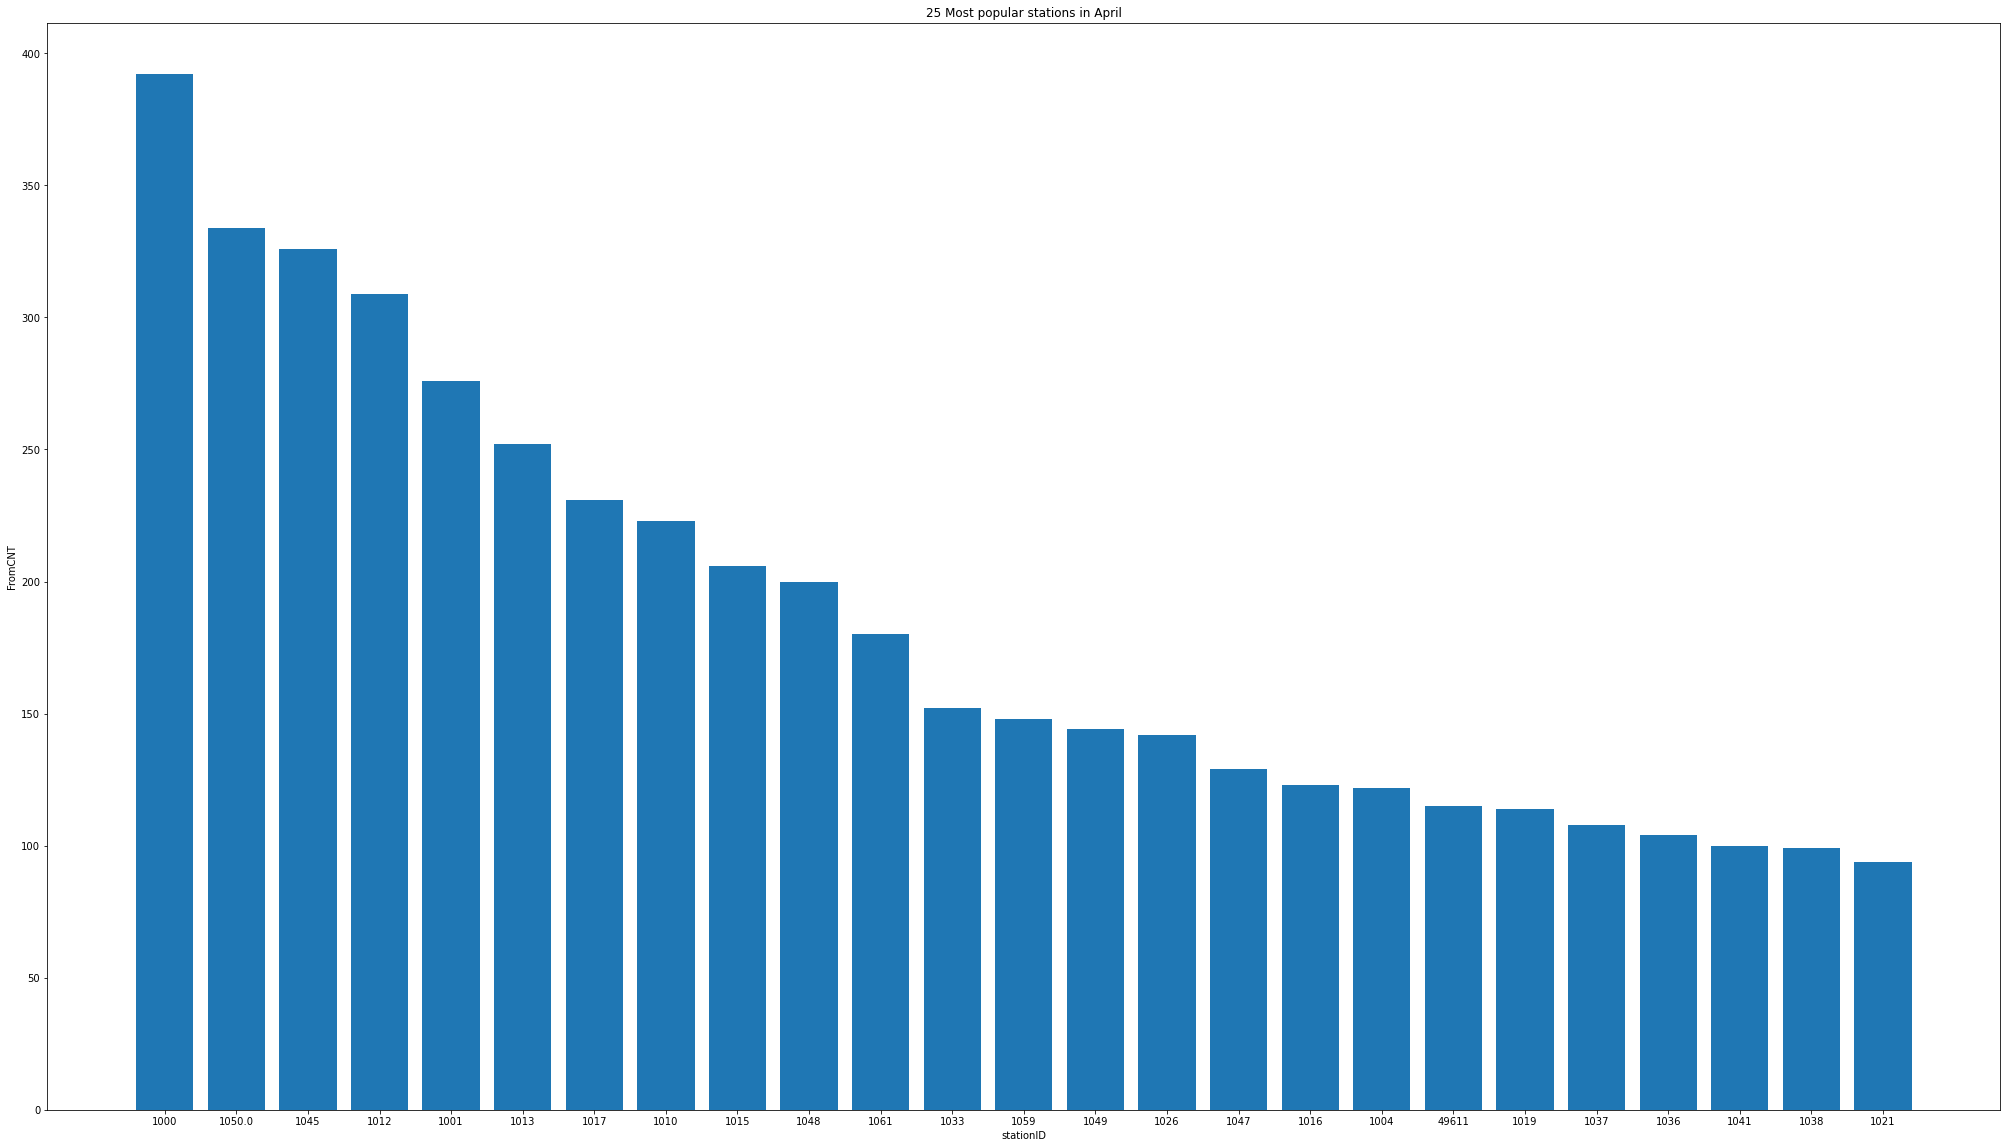

In [137]:
from_count_list = list()
station_ranking = [0]*25
for sta_id,month_reports in station_records_by_month.items():
    if filter_month in month_reports:
        from_count_list.append(month_reports[filter_month]['fromCNT'])
from_count_list.sort(reverse=True)

for id,data in station_records_by_month.items():
    if filter_month in data:
        fromCNT = data[filter_month]['fromCNT']
        index = (from_count_list).index(fromCNT)
        if index < 25:
            station_ranking[index] = str(id)
plt.figure(figsize=(35, 20))
plt.bar(station_ranking, from_count_list[0:25])
plt.title('25 Most popular stations in %s' % calendar.month_name[filter_month])
plt.xlabel('stationID')
plt.ylabel('FromCNT')
plt.show()
#print(station_ranking)

### Task 2.2

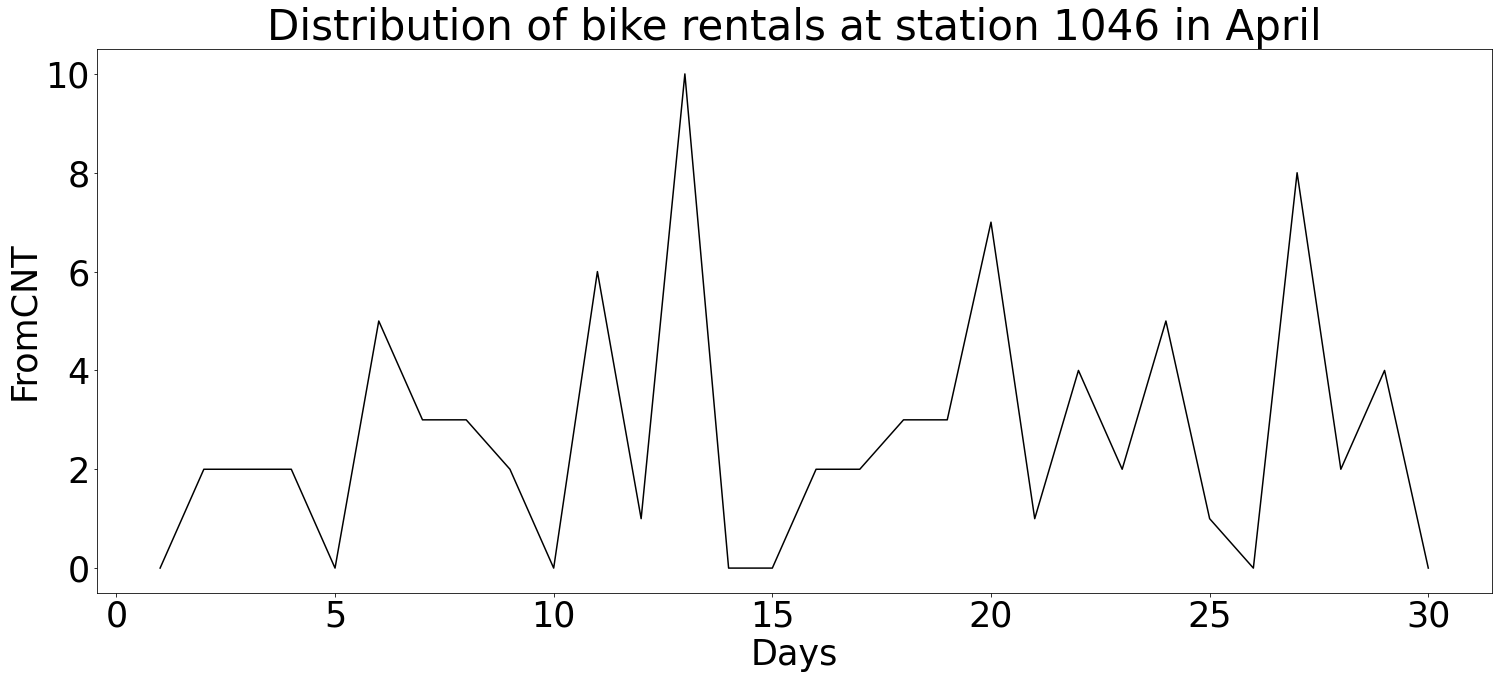

In [138]:

plt.rcParams.update({'font.size': 35})
days_list = []
fromCNT_for_each_day = []
tem = list(calendar.monthcalendar(2019, filter_month))
for li in tem:
    days_list += li
days_list = [datetime.strptime("%s/%s/19 00:00" % (filter_month,i),'%m/%d/%y %H:%M').date() for i in days_list if i != 0]
for day in days_list:
    if day in station_records[filter_stationID]:
        fr_cnt = station_records[filter_stationID][day]['fromCNT']
        fromCNT_for_each_day.append(fr_cnt)
    else:
        fromCNT_for_each_day.append(0)

days_list = [d.day for d in days_list]
plt.figure(figsize=(25, 10))
#pd.Series(fromCNT_for_each_day).plot.hist(grid=True, bins=8, rwidth=0.9,color='#607c8e')
plt.plot(days_list,fromCNT_for_each_day,color='black')                   
plt.title('Distribution of bike rentals at station %s in %s' % (filter_stationID,calendar.month_name[filter_month]))
plt.xlabel('Days')
plt.ylabel('FromCNT')
plt.show()

#print(fromCNT_for_each_day)


### Task 2.3

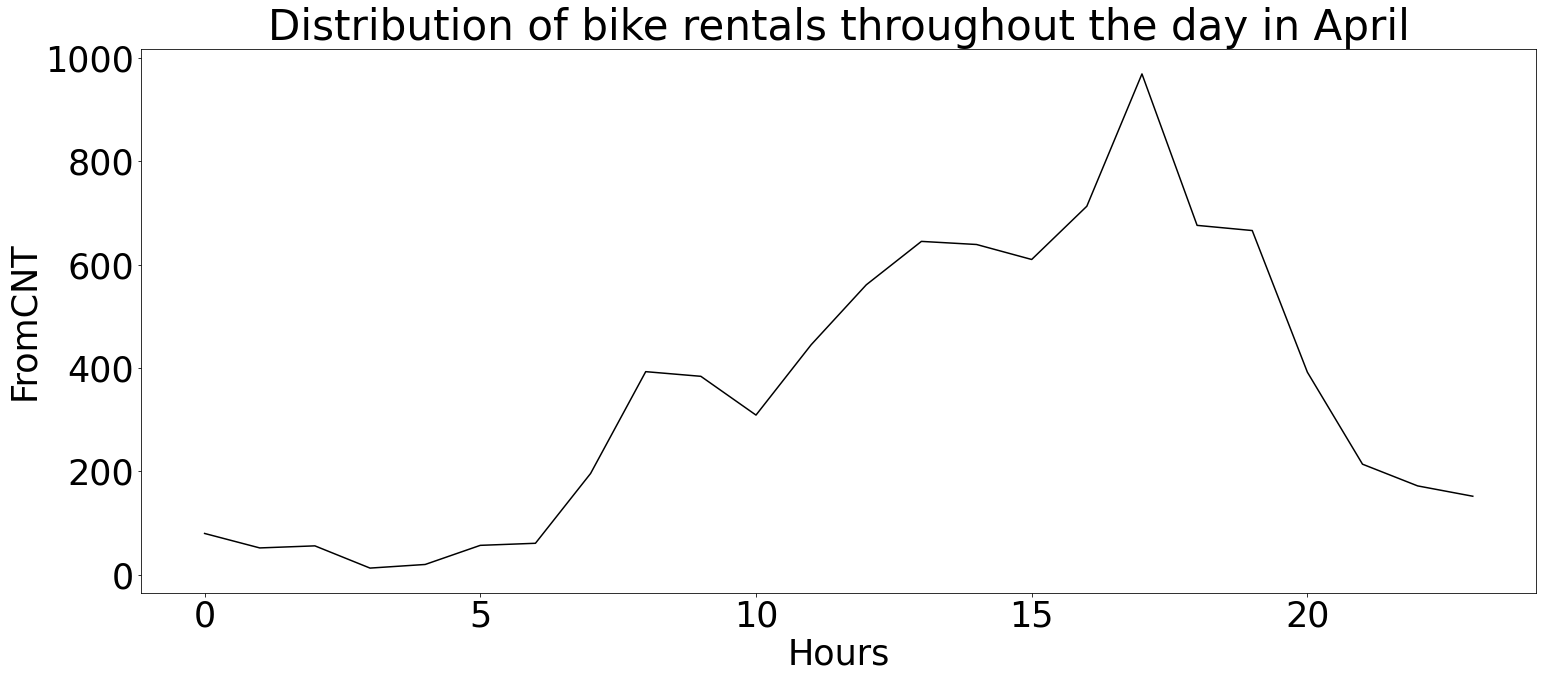

In [139]:
hours_list = [i for i in range(0,24)]
total_from_CNT_by_hours = [0]*24
for bike,data in dates_time.items():
    for date,count in data.items():
        if date.month == filter_month:
            if not math.isnan(count[0]):
                total_from_CNT_by_hours[date.hour] += 1
#print(total_from_CNT_by_hours)
plt.figure(figsize=(25, 10))
plt.plot(hours_list,total_from_CNT_by_hours,color='black')                   
plt.title('Distribution of bike rentals throughout the day in %s' % (calendar.month_name[filter_month]))
plt.xlabel('Hours')
plt.ylabel('FromCNT')
plt.show()

### Task 2.4

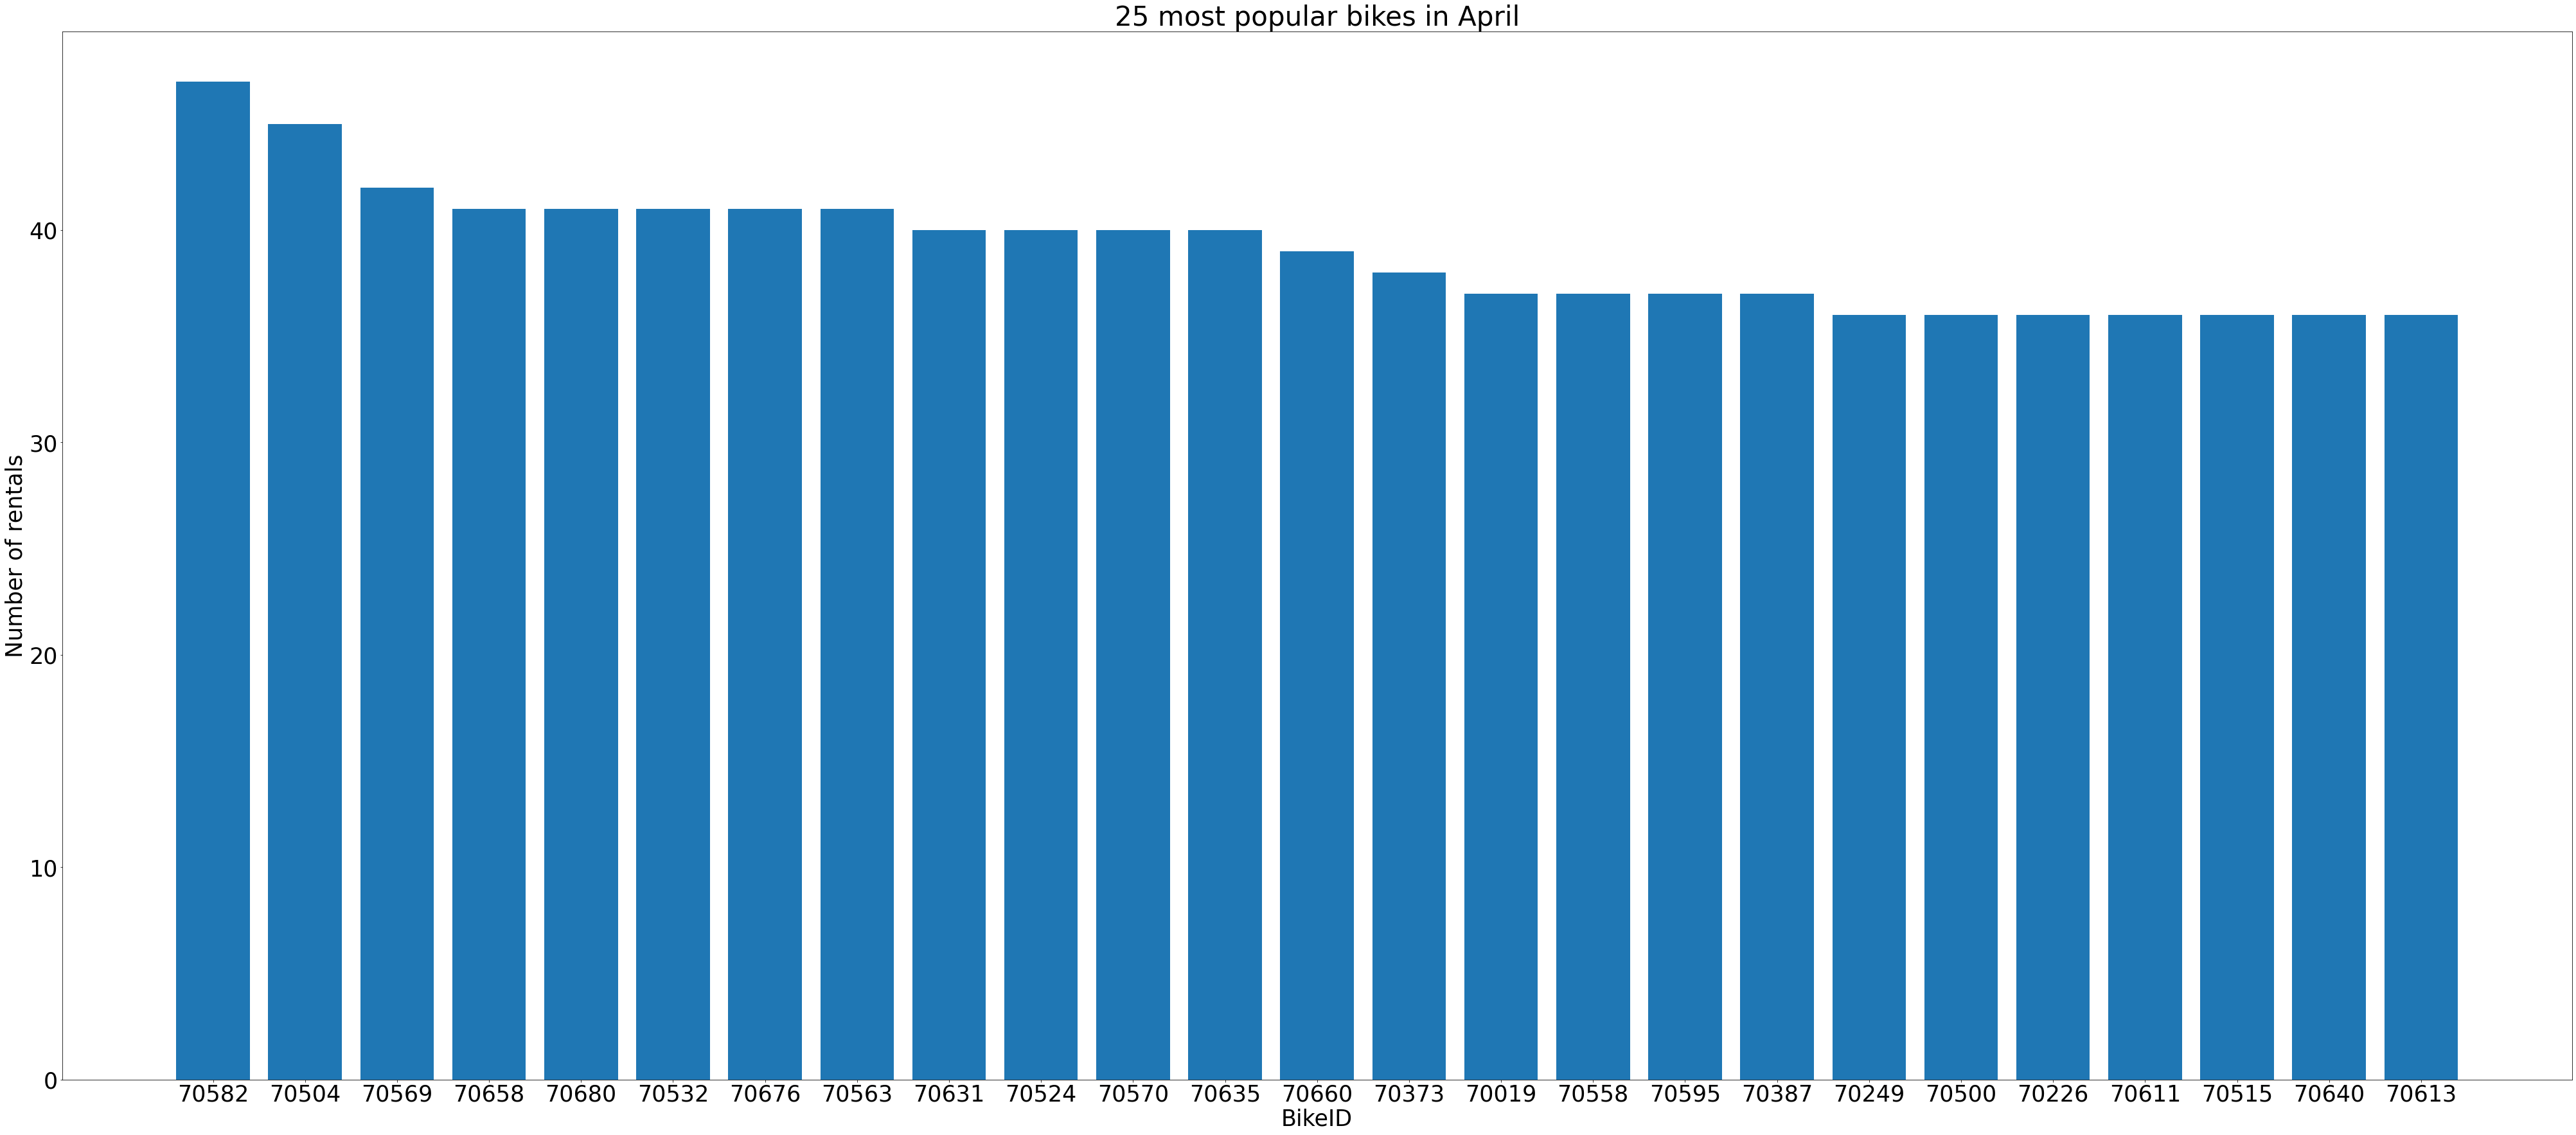

In [140]:
bike_id_list = [0]*25
rental_counts = dict()
rental_counts_sorted = list()
for bike,data in dates_time.items():
    monthly_count = 0
    for date,info in data.items():
        if date.month == filter_month:
            monthly_count += 1
    if monthly_count != 0:
        rental_counts_sorted.append(monthly_count)
        rental_counts[bike] = monthly_count
rental_counts_sorted = sorted(rental_counts_sorted,reverse=True)[0:25]
tem_list = rental_counts_sorted.copy()
for k,v in rental_counts.items():
    if v in tem_list:
        i = tem_list.index(v)
        bike_id_list[i] = k
        tem_list[i] = 0
bike_id_list = [str(i) for i in bike_id_list]
plt.figure(figsize=(70, 30))
ax = plt.bar(bike_id_list,rental_counts_sorted)
plt.title('25 most popular bikes in %s' % calendar.month_name[filter_month])
plt.xlabel('BikeID')
plt.ylabel('Number of rentals')
plt.show()


---
### Task 3

In this task you will create graphs to show the rebalancing issue.

### Task 3.1

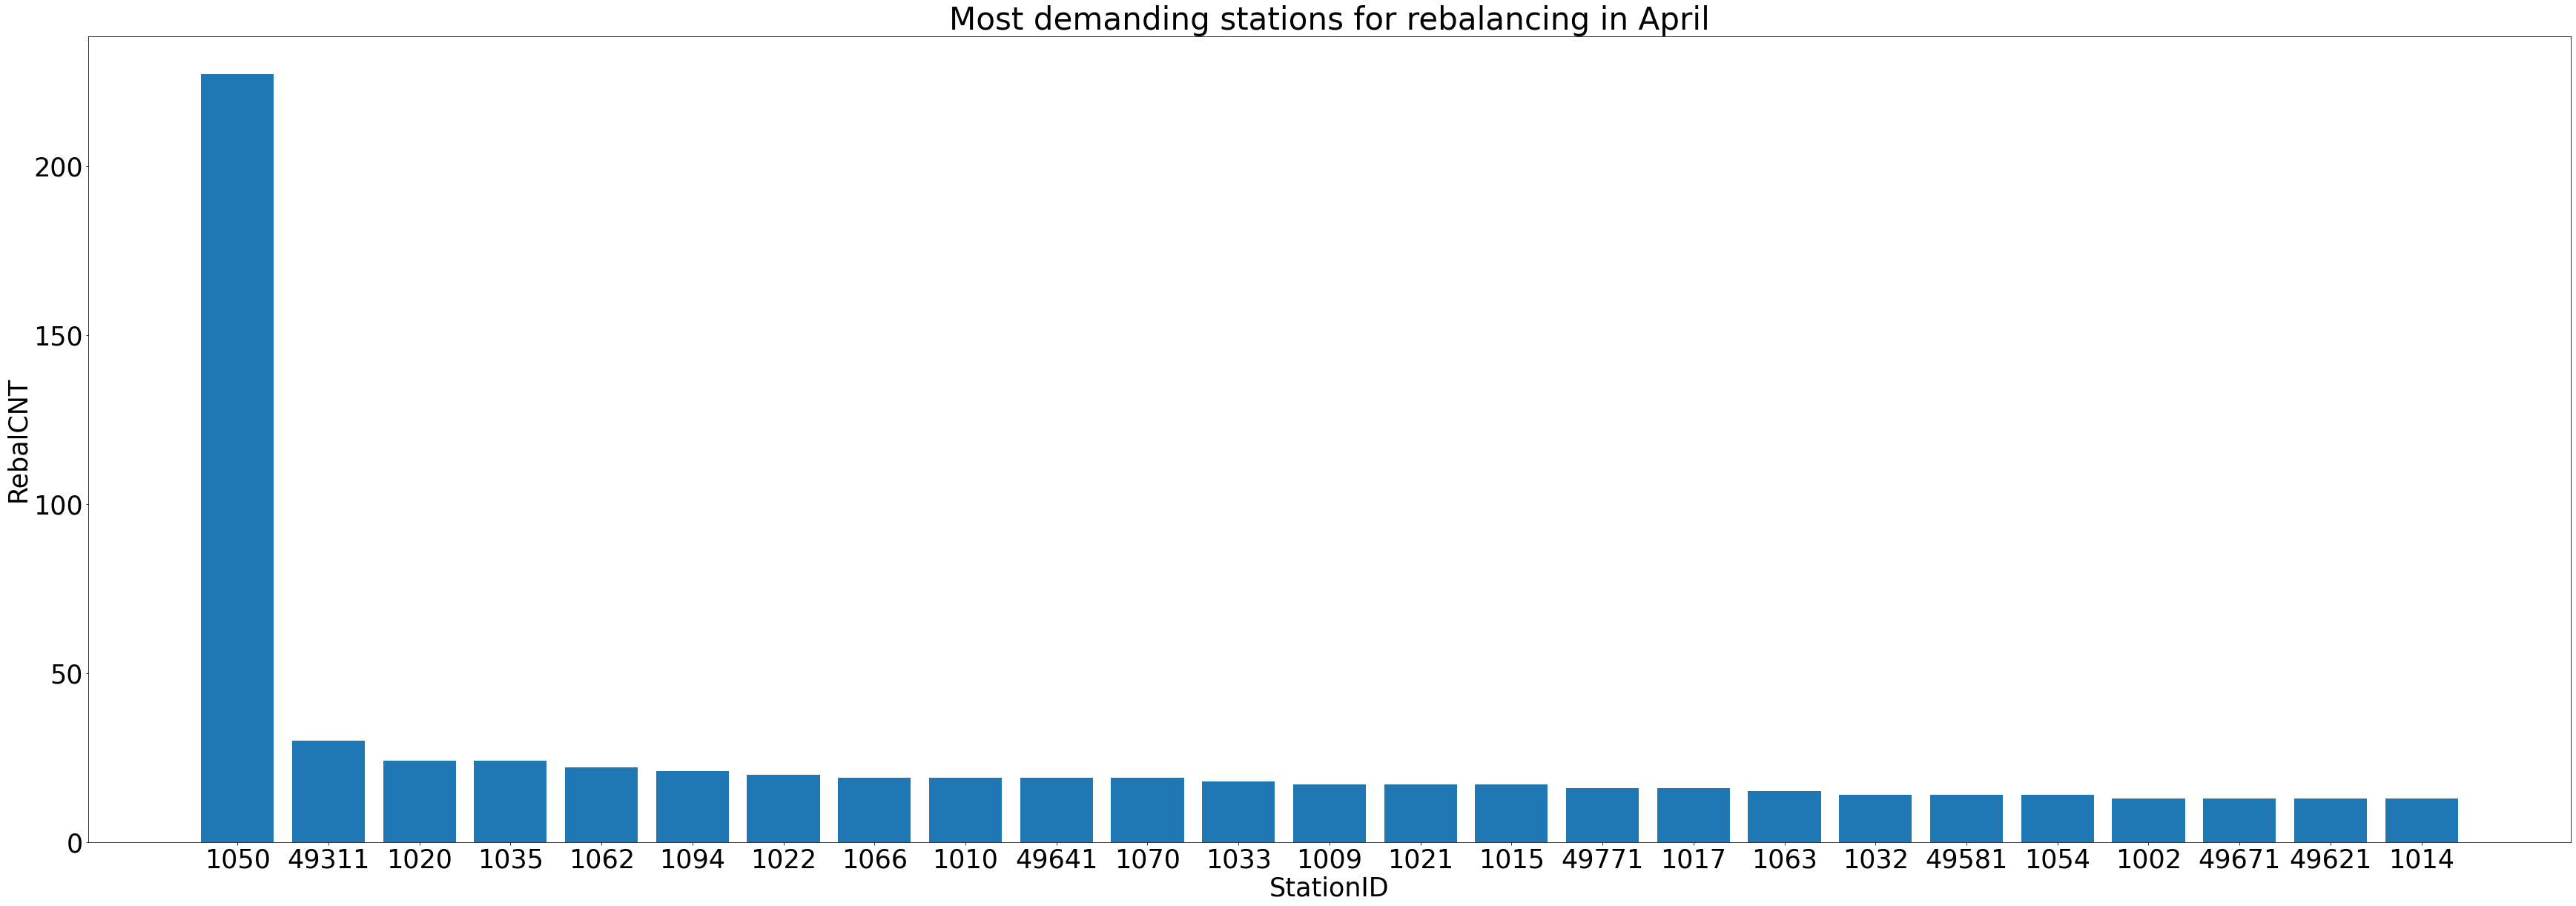

In [141]:
#plt.rcParams.update({'font.size':45})
rebal_count_list = list()
station_ranking = ['0'] * 25
for sta_id, month_reports in station_records_by_month.items():
    if filter_month in month_reports:
        rebal_count_list.append(month_reports[filter_month]['rebalCNT'])

rebal_count_list.sort(reverse=True)
tem_list = rebal_count_list[0:25].copy()

for id, data in station_records_by_month.items():
    if filter_month in data:
        rebalCNT = data[filter_month]['rebalCNT']
        if rebalCNT in tem_list:
            index = tem_list.index(rebalCNT)
            station_ranking[index] = str(int(id))
            tem_list[index] = 0
plt.figure(figsize=(60, 20))
plt.bar(station_ranking, rebal_count_list[0:25])
plt.title('Most demanding stations for rebalancing in %s' % calendar.month_name[filter_month])
plt.xlabel('StationID')
plt.ylabel('RebalCNT')
plt.show()

### Task 3.2

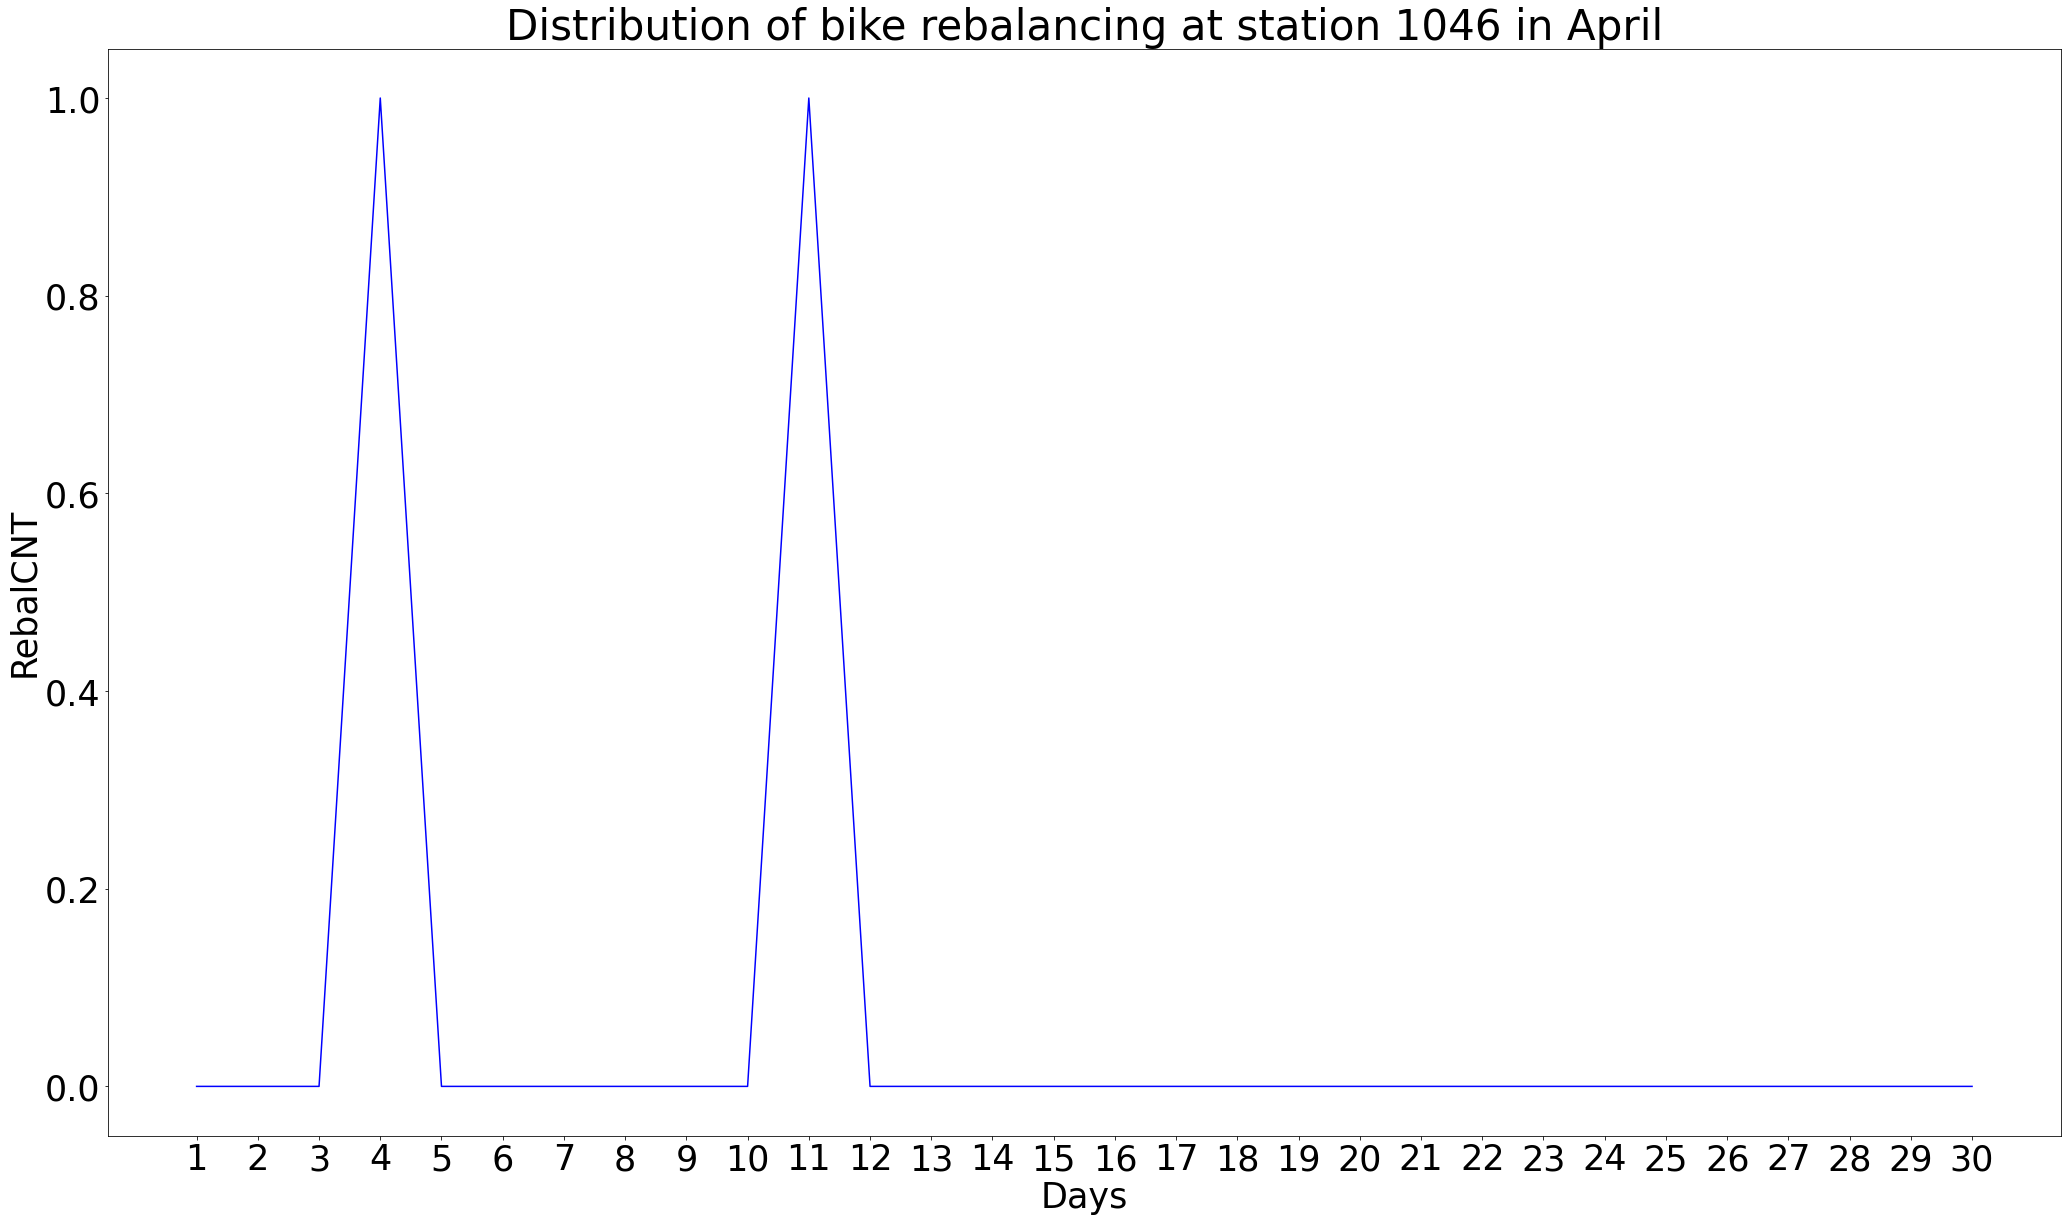

In [142]:
days_list = []
rebalCNT_for_each_day = []
tem = list(calendar.monthcalendar(2019, filter_month))
for li in tem:
    days_list += li
days_list = [datetime.strptime("%s/%s/19 00:00" % (filter_month, i), '%m/%d/%y %H:%M').date() for i in days_list if i != 0]
for day in days_list:
    if day in station_records[filter_stationID]:
        rebal_cnt = station_records[filter_stationID][day]['rebalCNT']
        rebalCNT_for_each_day.append(rebal_cnt)
    else:
        rebalCNT_for_each_day.append(0)
days_list = [str(d.day) for d in days_list]
plt.figure(figsize=(35, 20))
plt.plot(days_list,rebalCNT_for_each_day,color='blue')
plt.title('Distribution of bike rebalancing at station %s in %s' % (filter_stationID, calendar.month_name[filter_month]))
plt.xlabel('Days')
plt.ylabel('RebalCNT')
plt.show()

---
### Task 4

In this task you will cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.

### Task 4.1

In [153]:
from sklearn import cluster
from collections import Counter, defaultdict
df3 = pd.DataFrame()
def sort_dict(dict1):
    newdict = dict()
    item_list = sorted(dict1.values(),reverse=True)
    for i in item_list:
        for k,v in dict1.items():
            if v ==i:
                newdict[k] = v
    return newdict
# Kmean 1
k_means_1 = cluster.KMeans(n_clusters=4, init = 'k-means++',random_state=5000)
df3['from_cnt_7'] = [data['fromCNT'] if data is not None else 0 for data in df2[7]]
df3['from_cnt_8'] = [data['fromCNT'] if data is not None else 0 for data in df2[8]]
df3['from_cnt_9'] = [data['fromCNT'] if data is not None else 0 for data in df2[9]]
df3['rebal_cnt_7'] = [data['fromCNT'] if data is not None else 0 for data in df2[7]]
df3['rebal_cnt_8'] = [data['fromCNT'] if data is not None else 0 for data in df2[8]]
df3['rebal_cnt_9'] = [data['fromCNT'] if data is not None else 0 for data in df2[9]]
data = df3[['from_cnt_7','from_cnt_8','from_cnt_9','rebal_cnt_7','rebal_cnt_8','rebal_cnt_9']]
k_means_1.fit(data)
cluster1 = sort_dict(Counter(k_means_1.labels_))

# Kmean 2
k_means_2 = cluster.KMeans(n_clusters=5, init = 'k-means++',random_state=5000)
k_means_2.fit(data)
cluster2 = sort_dict(Counter(k_means_2.labels_))
# Kmean 3
k_means_3 = cluster.KMeans(n_clusters=6, init = 'k-means++',random_state=5000)
k_means_3.fit(data)
cluster3 = sort_dict(Counter(k_means_3.labels_))

# DBscan 1
DBscan_1 = cluster.DBSCAN(eps=20,min_samples=2).fit(data)
cluster4 = sort_dict(Counter(DBscan_1.labels_))
cluster4.pop(-1)

# DBscan 2
DBscan_2 = cluster.DBSCAN(eps=15,min_samples=3).fit(data)
cluster5 = sort_dict(Counter(DBscan_2.labels_))
cluster5.pop(-1)

# DBscan 3
DBscan_3 = cluster.DBSCAN(eps=25,min_samples=5).fit(data)
cluster6 = sort_dict(Counter(DBscan_3.labels_))
cluster6.pop(-1)
print("Clusters:",cluster1,cluster2,cluster3,cluster4,cluster5,cluster6)

Clusters: {0: 59, 3: 38, 2: 16, 1: 6} {0: 54, 4: 33, 3: 18, 1: 10, 2: 4} {0: 32, 4: 28, 5: 27, 3: 18, 1: 10, 2: 4} {0: 23, 9: 9, 1: 6, 2: 3, 3: 3, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 10: 2} {3: 7, 1: 6, 0: 4, 2: 3} {0: 25, 1: 10, 2: 9}


### Task 4.2

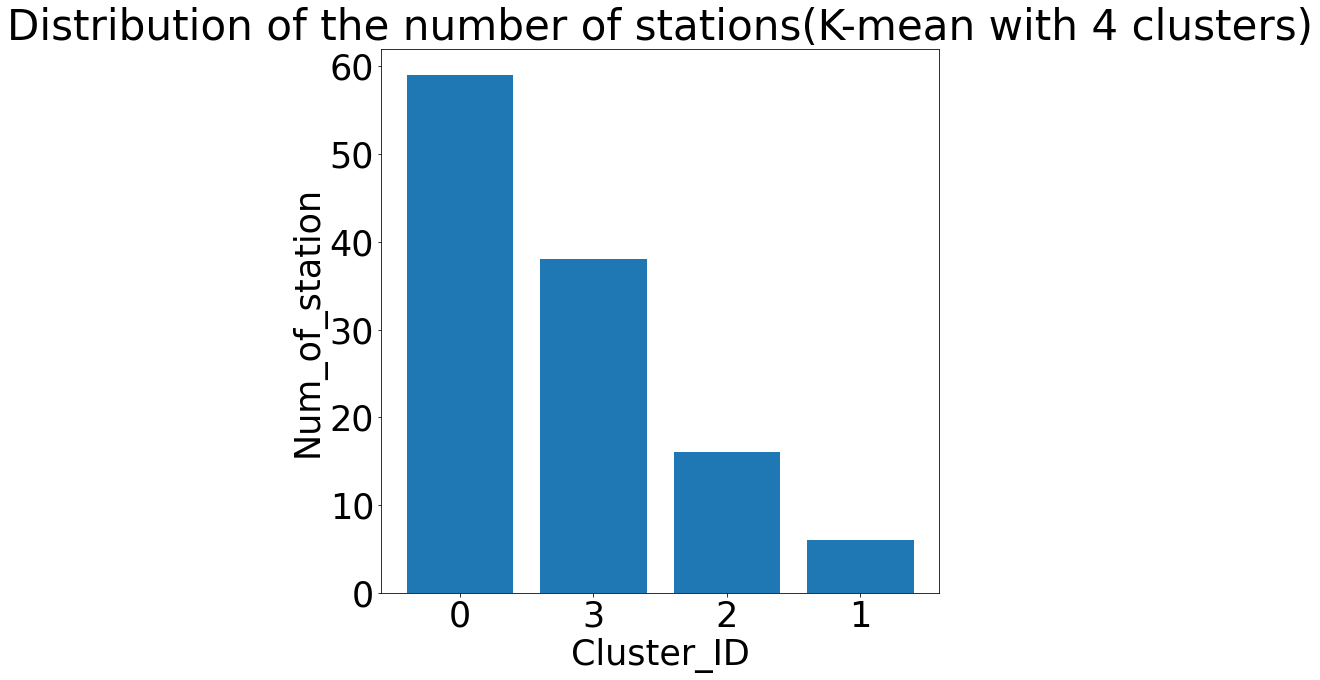

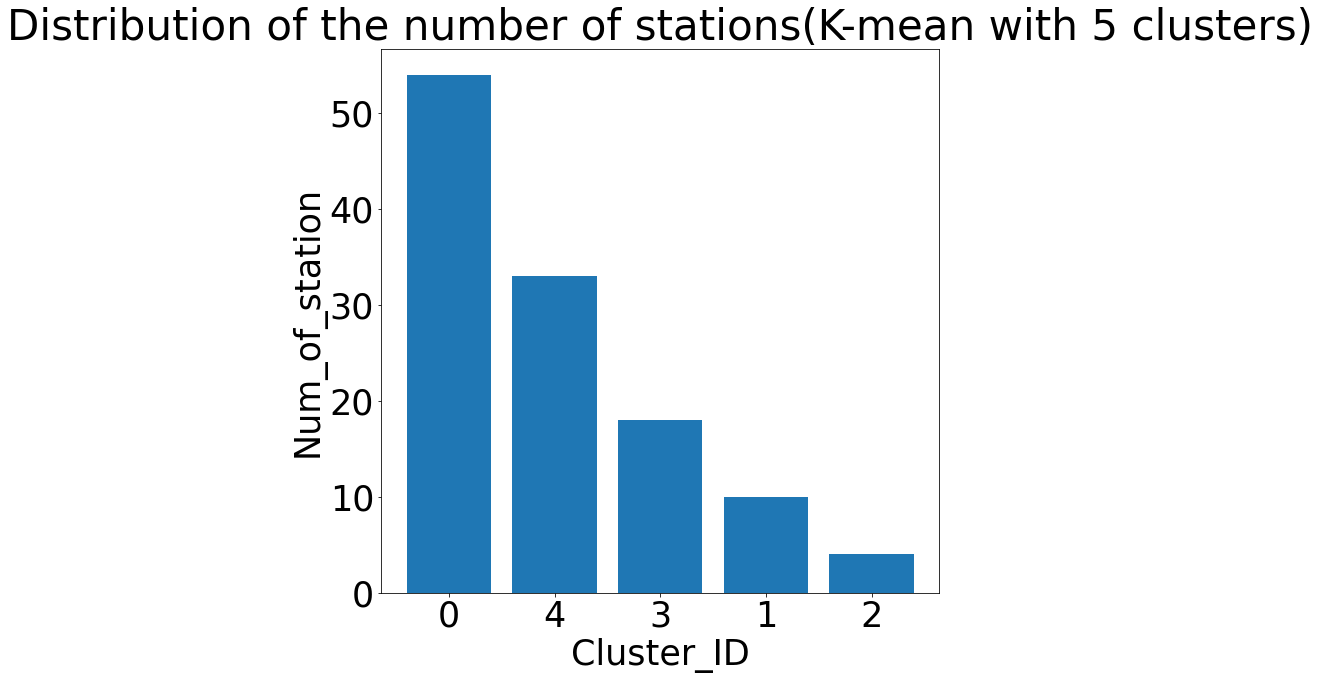

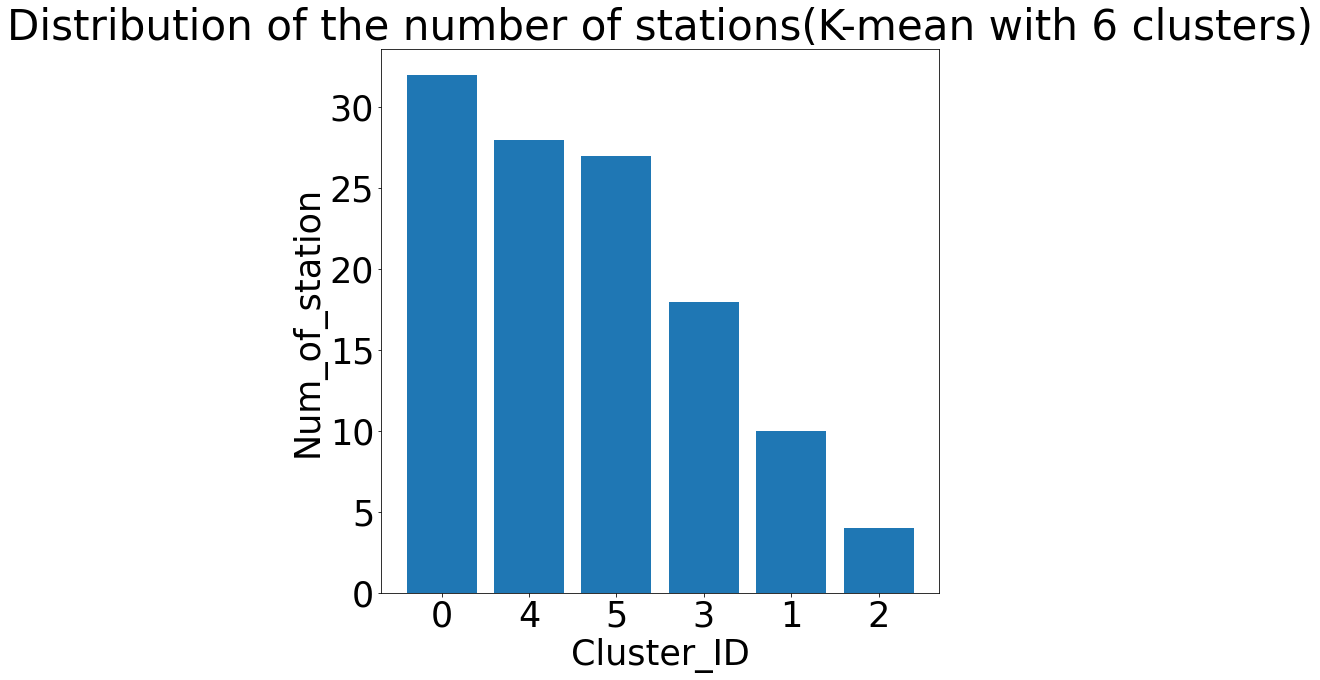

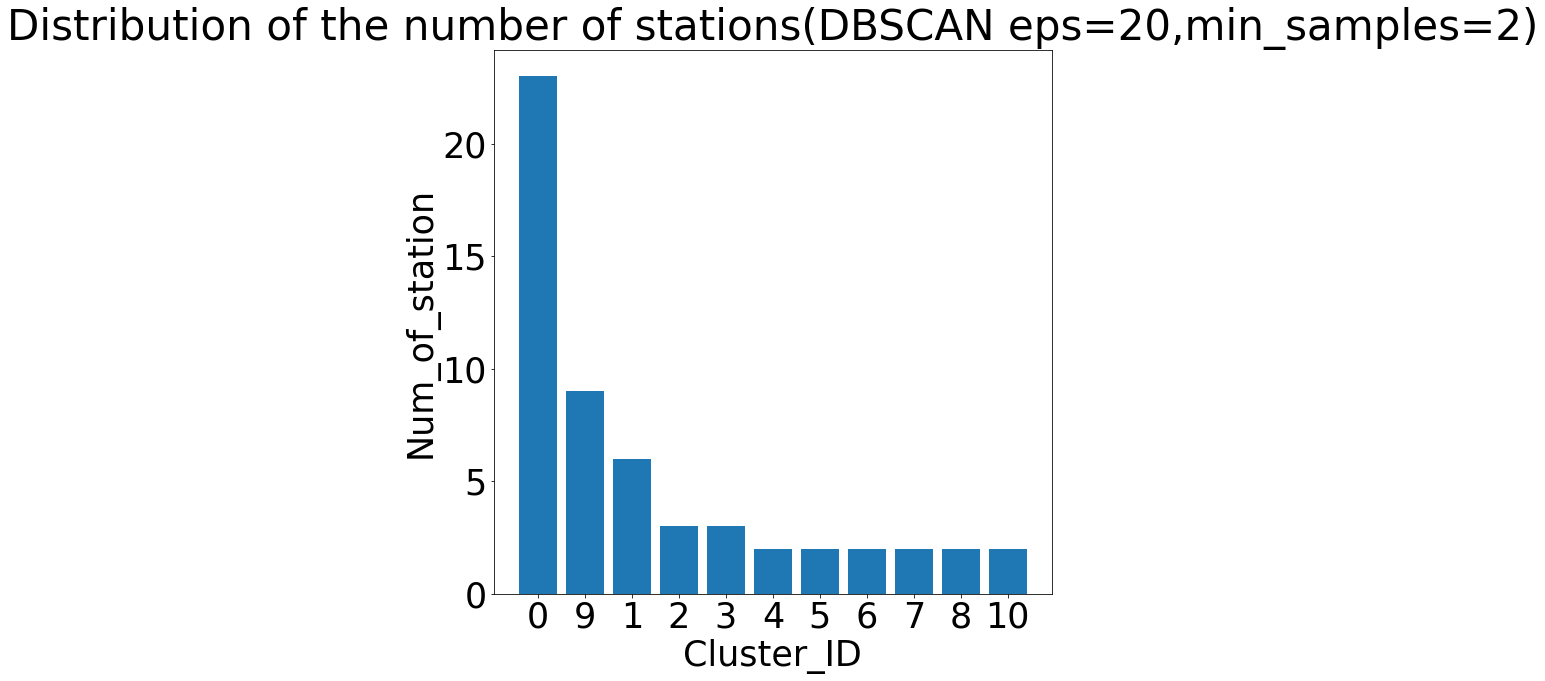

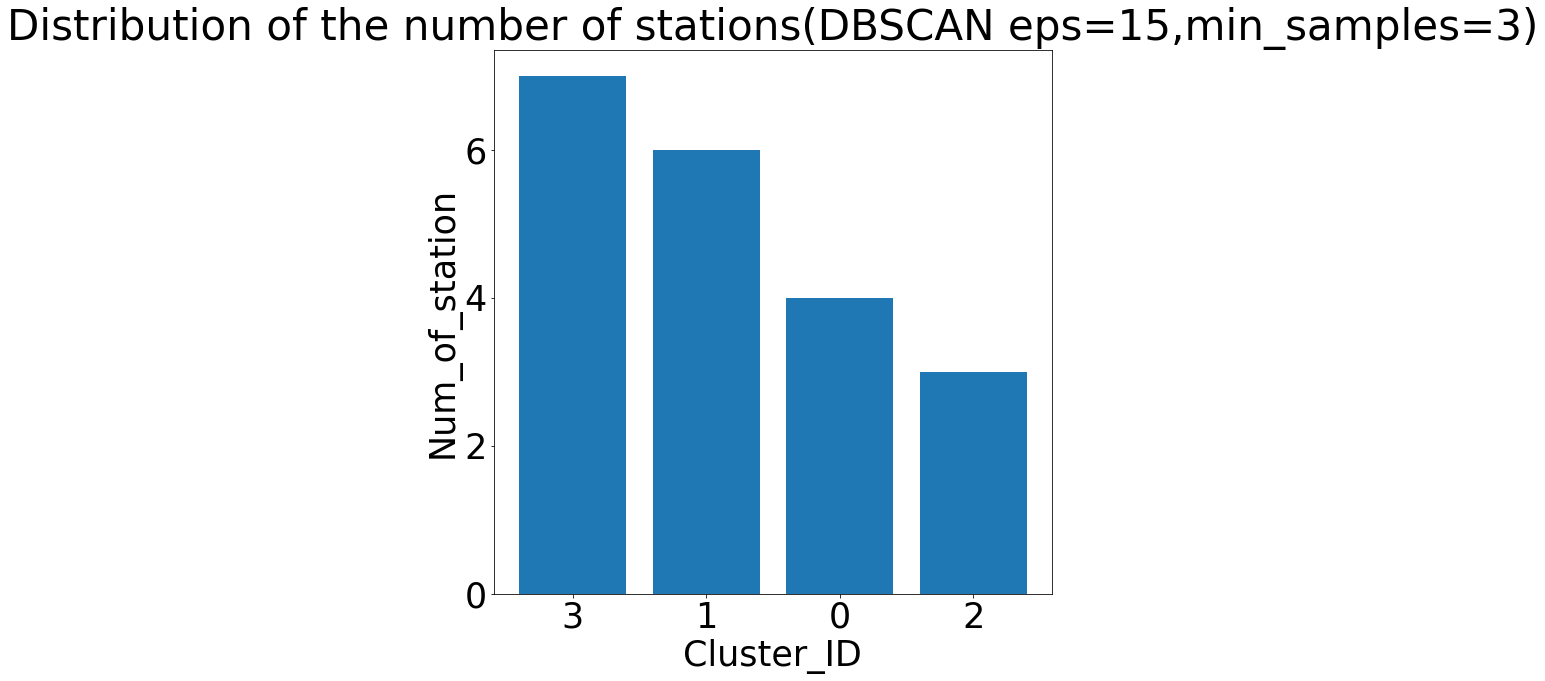

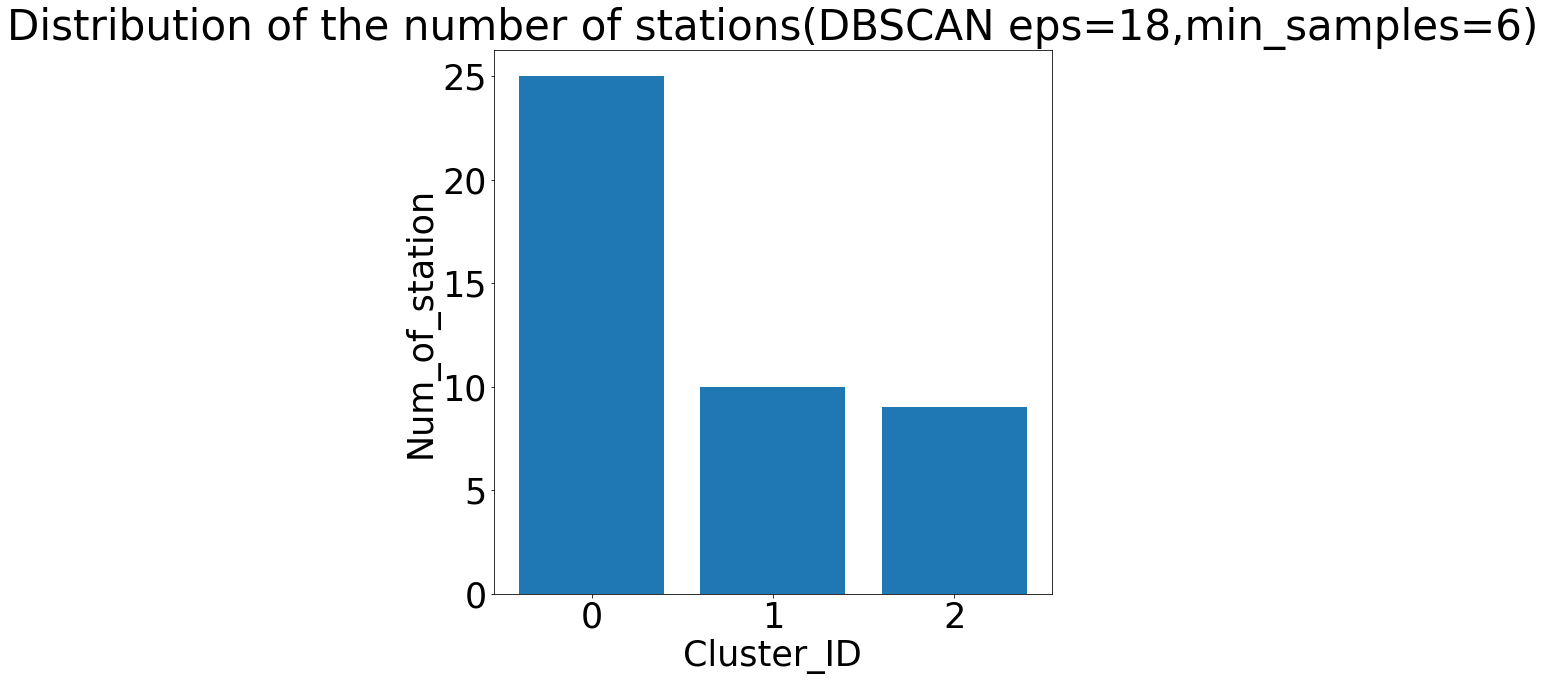

In [161]:
# Bar chart for k_mean_1
plt.figure(figsize=(10, 10))
plt.bar([str(i) for i in cluster1.keys()], cluster1.values())
plt.title('Distribution of the number of stations(K-mean with 4 clusters)')
plt.xlabel('Cluster_ID')
plt.ylabel('Num_of_station')
plt.show()

# Bar chart for k_mean_2
plt.figure(figsize=(10, 10))
plt.bar([str(i) for i in cluster2.keys()],cluster2.values())
plt.title('Distribution of the number of stations(K-mean with 5 clusters)')
plt.xlabel('Cluster_ID')
plt.ylabel('Num_of_station')
plt.show()

# Bar chart for k_mean_3
plt.figure(figsize=(10, 10))
plt.bar([str(i) for i in cluster3.keys()],cluster3.values())
plt.title('Distribution of the number of stations(K-mean with 6 clusters)')
plt.xlabel('Cluster_ID')
plt.ylabel('Num_of_station')
plt.show()

# Bar chart for Dbscan_1
plt.figure(figsize=(10, 10))
plt.bar([str(i) for i in cluster4.keys()],cluster4.values())
plt.title('Distribution of the number of stations(DBSCAN eps=20,min_samples=2)')
plt.xlabel('Cluster_ID')
plt.ylabel('Num_of_station')
plt.show()

# Bar chart for Dbscan_2
plt.figure(figsize=(10, 10))
plt.bar([str(i) for i in cluster5.keys()],cluster5.values())
plt.title('Distribution of the number of stations(DBSCAN eps=15,min_samples=3)')
plt.xlabel('Cluster_ID')
plt.ylabel('Num_of_station')
plt.show()

# Bar chart for Dbscan_3
plt.figure(figsize=(10, 10))
plt.bar([str(i) for i in cluster6.keys()],cluster6.values())
plt.title('Distribution of the number of stations(DBSCAN eps=18,min_samples=6)')
plt.xlabel('Cluster_ID')
plt.ylabel('Num_of_station')
plt.show()


### Task 4.3

In [145]:
# My best choice of K is 6 since, comparetively speaking,the spread of each cluster is more even and the data within each cluster seem closer to the centriod
# I think Dbscan is the better clustering algorithm here, we can see from the bar charts, if we disregard the noises, clearly the dbscan produces more uniform and evenly distributed clusters comparing to K-Mean.